In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn
from jax import tree_util
from typing import NamedTuple, Callable, Tuple
import matplotlib.pyplot as plt
import pickle

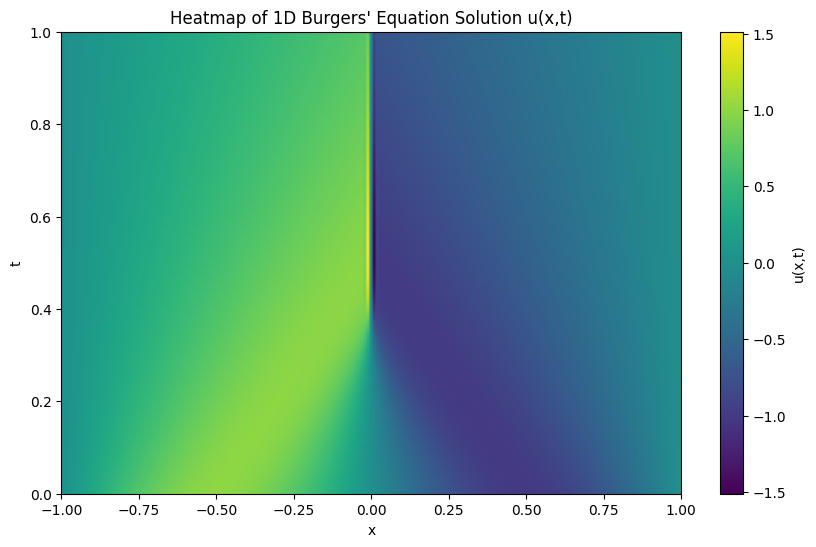

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nx = 201                      # Spatial resolution
x = np.linspace(-1, 1, nx)    # Spatial domain
dx = x[1] - x[0]
nu = 0.01 / np.pi             # Viscosity
dt = 0.0005                   # Time step
T = 1.0                       # Final time
nt = int(T / dt)              # Number of time steps
t = np.linspace(0, T, nt)     # Time domain

# Initial condition
u = -np.sin(np.pi * x)
u[0] = 0
u[-1] = 0

# Storage for u(x,t)
U = np.zeros((nt, nx))
U[0, :] = u

# Time stepping loop
for n in range(1, nt):
    un = u.copy()
    for i in range(1, nx - 1):
        u[i] = (un[i]
                - dt / (2 * dx) * un[i] * (un[i + 1] - un[i - 1])
                + nu * dt / dx**2 * (un[i + 1] - 2 * un[i] + un[i - 1]))

    # Enforce boundary conditions
    u[0] = 0
    u[-1] = 0

    U[n, :] = u

# Plotting the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(U, extent=[-1, 1, 0, T], aspect='auto', origin='lower',
           cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Heatmap of 1D Burgers' Equation Solution u(x,t)")
plt.show()

import pickle

# Save solution for later comparison
with open("fdm_solution.pkl", "wb") as f:
    pickle.dump({'U': U, 'x': x, 't': t}, f)

In [3]:
class PINN(nn.Module):
    hidden_sizes: Tuple[int,...] = (64,64,64)
    @nn.compact
    def __call__(self, x, t):
        h = jnp.stack([x, t], -1)
        for w in self.hidden_sizes:
            h = nn.tanh(nn.Dense(w)(h))
        return nn.Dense(1)(h).squeeze(-1)

In [4]:
def generate_data(key, N_f=10_000, N_i=1_000, N_b=1_000):
    k1, k2, k3 = jax.random.split(key, 3)
    x_f = jax.random.uniform(k1, (N_f,), minval=-1, maxval=1)
    t_f = jax.random.uniform(k2, (N_f,), minval=0, maxval=1)
    x_i = jnp.linspace(-1, 1, N_i); t_i = jnp.zeros_like(x_i)
    u_i = -jnp.sin(jnp.pi * x_i)
    t_b = jax.random.uniform(k3, (N_b,), minval=0, maxval=1)
    x_lb, x_rb = -jnp.ones_like(t_b), jnp.ones_like(t_b)
    u_b = jnp.zeros_like(t_b)
    return (x_f, t_f), (x_i, t_i, u_i), (x_lb, x_rb, t_b, u_b)

In [5]:
def pde_residual(params, x, t, model, nu=0.01/jnp.pi):
    u_fn = lambda xx, tt: model.apply(params, xx, tt)
    u_x  = jax.grad(u_fn, argnums=0)(x, t)
    u_t  = jax.grad(u_fn, argnums=1)(x, t)
    u_xx = jax.grad(lambda xx, tt: jax.grad(u_fn, argnums=0)(xx, tt), argnums=0)(x, t)
    return u_t + u_fn(x, t) * u_x - nu * u_xx

def loss_fn(params, batch, model):
    (x_f, t_f), (x_i, t_i, u_i), (x_lb, x_rb, t_b, u_b) = batch
    li = jnp.mean((model.apply(params, x_i, t_i) - u_i)**2)
    lb = jnp.mean((model.apply(params, x_lb, t_b) - u_b)**2 + (model.apply(params, x_rb, t_b) - u_b)**2)
    res = jax.vmap(lambda xx, tt: pde_residual(params, xx, tt, model))(x_f, t_f)
    lf = jnp.mean(res**2)
    return li + lb + lf

In [6]:
class SoapState(NamedTuple):
    count: jnp.ndarray
    m: any
    v: any

def init_soap_state(params):
    zeros = lambda p: jnp.zeros_like(p)
    return SoapState(count=jnp.zeros([], jnp.int32),
                     m=tree_util.tree_map(zeros, params),
                     v=tree_util.tree_map(zeros, params))

def make_soap_trainer(model, lr=1e-3, b1=0.9, b2=0.999, eps=1e-8):
    @jax.jit
    def step(params, state, batch):
        (x_f, t_f), ic, bc = batch
        loss, grads_tot = jax.value_and_grad(lambda p: loss_fn(p, batch, model))(params)
        g_res = jax.vmap(lambda xx, tt: jax.grad(
            lambda pp, xx_, tt_: pde_residual(pp, xx_, tt_, model), argnums=0)(params, xx, tt)
        )(x_f, t_f)
        v_new = tree_util.tree_map(lambda v_old, g: b2*v_old + (1-b2)*jnp.mean(g**2, axis=0), state.v, g_res)
        m_new = tree_util.tree_map(lambda m_old, g: b1*m_old + (1-b1)*g, state.m, grads_tot)
        m_hat = tree_util.tree_map(lambda m, v: m / (jnp.sqrt(v) + eps), m_new, v_new)
        p_new = tree_util.tree_map(lambda w, mm: w - lr*mm, params, m_hat)
        s_new = SoapState(state.count+1, m_new, v_new)
        return p_new, s_new, loss

    def init(params):
        return init_soap_state(params)

    return init, step

In [7]:
def make_adam_trainer(model, lr=1e-3):
    optimizer = optax.adam(lr)

    @jax.jit
    def step(params, opt_state, batch):
        loss, grads = jax.value_and_grad(lambda p: loss_fn(p, batch, model))(params)
        updates, new_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state, loss

    def init(params):
        return optimizer.init(params)

    return init, step

In [12]:
def train(rng, model, trainer_init, trainer_step, num_epochs=2000, batch_size=1024):
    params = model.init(rng, jnp.zeros((1,)), jnp.zeros((1,)))
    opt_state = trainer_init(params)
    data = generate_data(rng)
    x_f, _ = data[0]
    num_batches = x_f.shape[0] // batch_size
    history = []
    for ep in range(1, num_epochs+1):
        perm = np.random.permutation(x_f.shape[0])
        epoch_loss = 0.0
        for i in range(num_batches):
            idx = perm[i*batch_size:(i+1)*batch_size]
            batch = ((data[0][0][idx], data[0][1][idx]), data[1], data[2])
            params, opt_state, loss = trainer_step(params, opt_state, batch)
            epoch_loss += float(loss)
        epoch_loss /= num_batches
        history.append(epoch_loss)
        if ep == 1 or ep % 200 == 0:
            print(f"Epoch {ep:4d} | Loss {epoch_loss:.3e}")
    return params, history

In [13]:
def evaluate_model(params, model, x, t):
    xt = jnp.stack([x.flatten(), t.flatten()], axis=-1)
    preds = model.apply(params, xt[:,0], xt[:,1])
    return np.array(preds).reshape(x.shape)

def plot_heatmap(U, x, t, title, cmap='viridis', vmin=None, vmax=None):
    plt.figure(figsize=(10, 6))
    plt.imshow(U, extent=[x[0], x[-1], t[0], t[-1]], aspect='auto',
               origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(label='u(x,t)' if 'Error' not in title else '|Error|')
    plt.xlabel('x'); plt.ylabel('t')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [14]:
def compare_with_fdm(fdm_path, model, soap_params, adam_params):
    with open(fdm_path, "rb") as f:
        data = pickle.load(f)
    U_fdm, x, t = data['U'], data['x'], data['t']
    X, T = np.meshgrid(x, t)

    U_soap = evaluate_model(soap_params, model, X, T)
    U_adam = evaluate_model(adam_params, model, X, T)

    # ── 1. Line plots at time slices ─────────────────────────────
    for time_idx in [0, int(0.25*len(t)), int(0.5*len(t)), int(0.75*len(t)), -1]:
        plt.figure(figsize=(8,4))
        plt.plot(x, U_fdm[time_idx, :], label="FDM", lw=2)
        plt.plot(x, U_adam[time_idx, :], '--', label="Adam", lw=2)
        plt.plot(x, U_soap[time_idx, :], ':', label="SOAP", lw=2)
        plt.title(f"Comparison at t = {t[time_idx]:.3f}")
        plt.xlabel("x"); plt.ylabel("u(x,t)")
        plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ── 2. Set common value range for fair color scaling ────────
    umin = min(U_fdm.min(), U_adam.min(), U_soap.min())
    umax = max(U_fdm.max(), U_adam.max(), U_soap.max())

    plot_heatmap(U_fdm,  x, t, "Heatmap of FDM Solution",  vmin=umin, vmax=umax)
    plot_heatmap(U_adam, x, t, "Heatmap of Adam PINN",      vmin=umin, vmax=umax)
    plot_heatmap(U_soap, x, t, "Heatmap of SOAP PINN",      vmin=umin, vmax=umax)

    # ── 3. Error heatmaps (same color scale) ───────────────────
    error_adam = np.abs(U_fdm - U_adam)
    error_soap = np.abs(U_fdm - U_soap)
    emax = max(error_adam.max(), error_soap.max())

    plot_heatmap(error_adam, x, t, "Absolute Error: |FDM - Adam|", cmap='plasma', vmin=0, vmax=emax)
    plot_heatmap(error_soap, x, t, "Absolute Error: |FDM - SOAP|", cmap='plasma', vmin=0, vmax=emax)

Training with SOAP Optimizer...
Epoch    1 | Loss 1.359e+00
Epoch  200 | Loss 1.347e-01
Epoch  400 | Loss 1.180e-01
Epoch  600 | Loss 1.109e-01
Epoch  800 | Loss 1.039e-01
Epoch 1000 | Loss 9.710e-02
Epoch 1200 | Loss 9.172e-02
Epoch 1400 | Loss 8.658e-02
Epoch 1600 | Loss 8.268e-02
Epoch 1800 | Loss 7.677e-02
Epoch 2000 | Loss 7.019e-02

Training with Adam Optimizer...
Epoch    1 | Loss 4.546e-01
Epoch  200 | Loss 6.687e-02
Epoch  400 | Loss 4.202e-02
Epoch  600 | Loss 3.123e-02
Epoch  800 | Loss 1.941e-02
Epoch 1000 | Loss 7.988e-03
Epoch 1200 | Loss 6.464e-03
Epoch 1400 | Loss 8.175e-03
Epoch 1600 | Loss 5.111e-03
Epoch 1800 | Loss 5.090e-03
Epoch 2000 | Loss 4.436e-03

Final losses → SOAP:  0.07018560585048464  | Adam:  0.004435750216038691


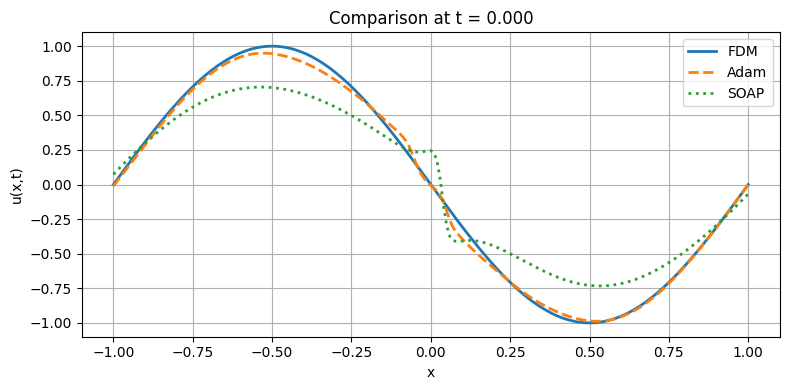

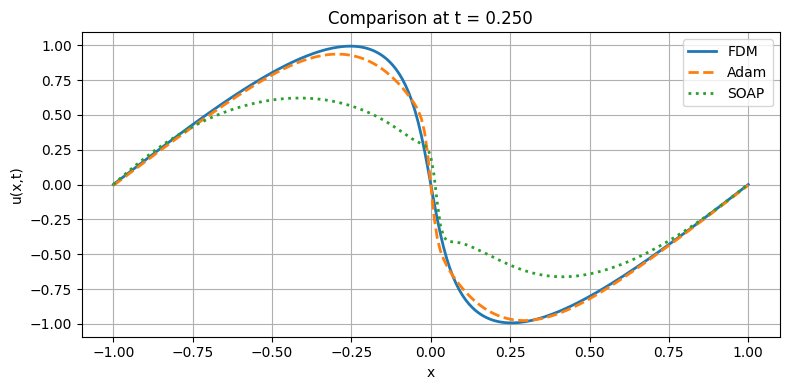

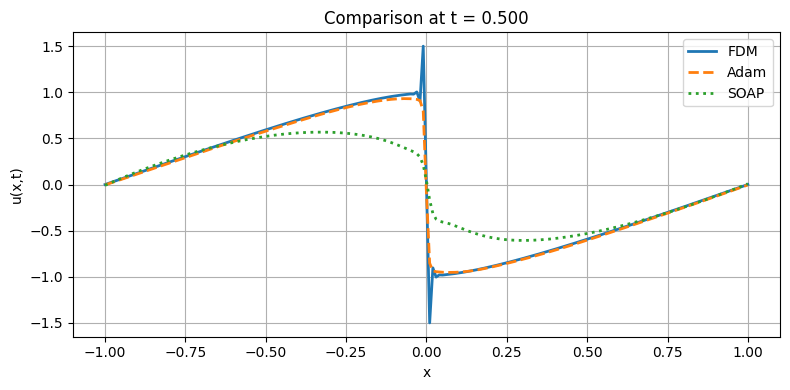

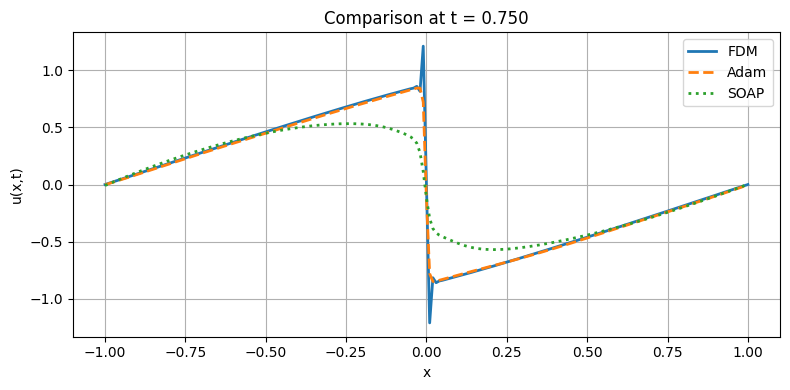

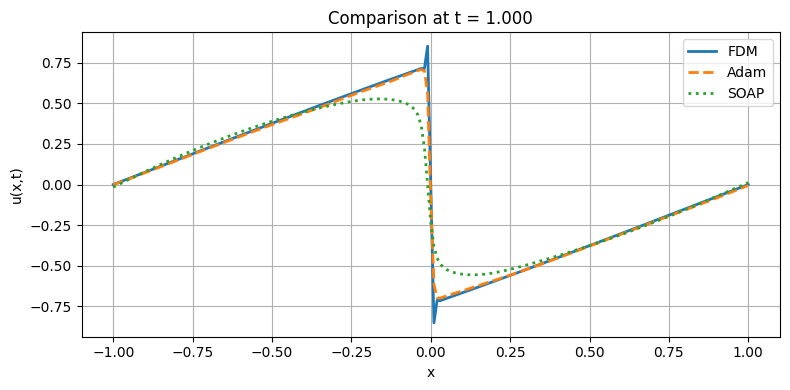

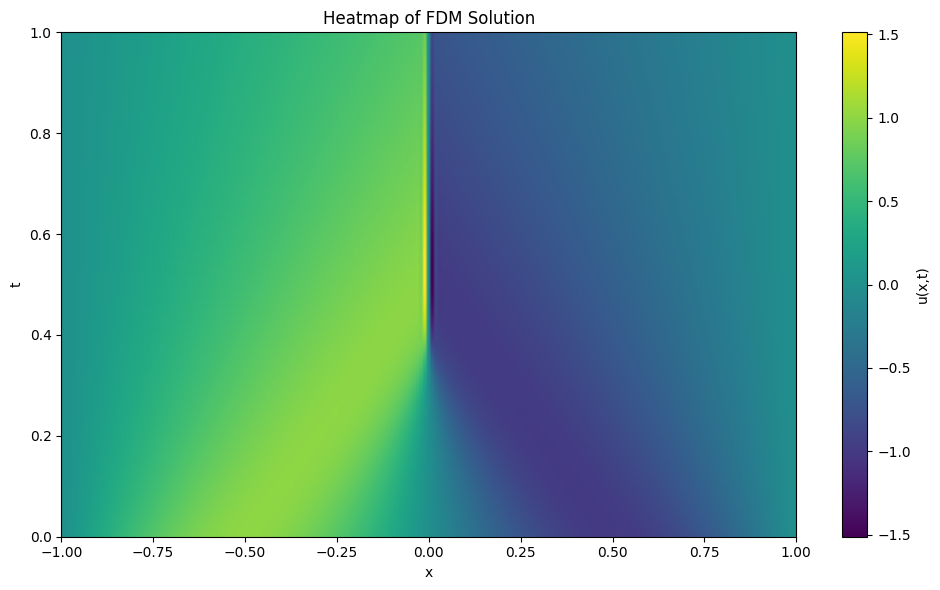

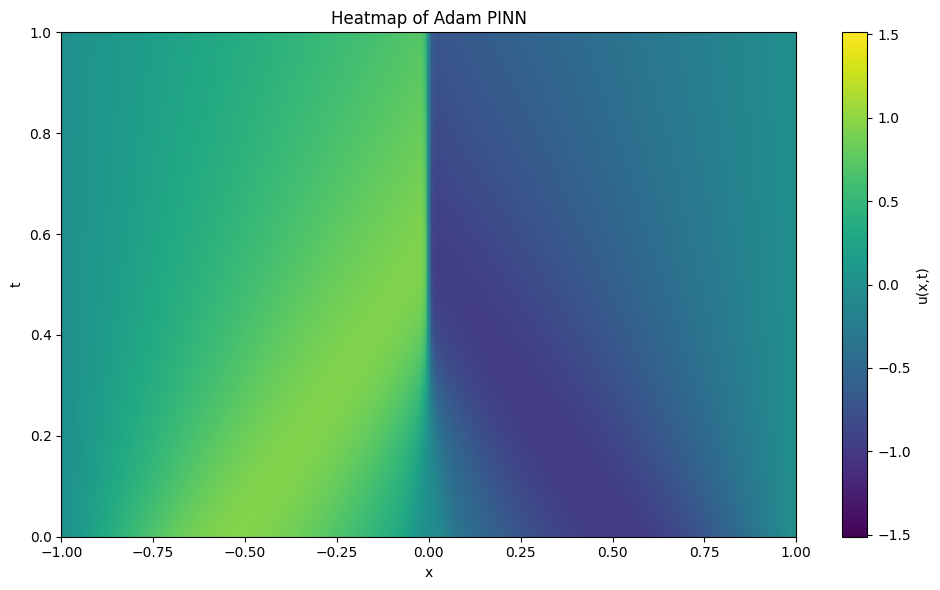

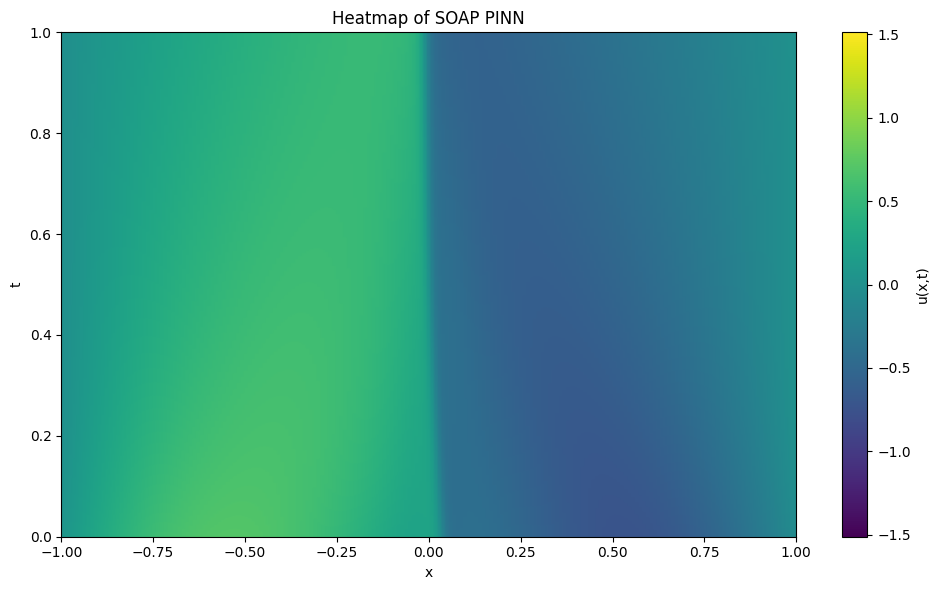

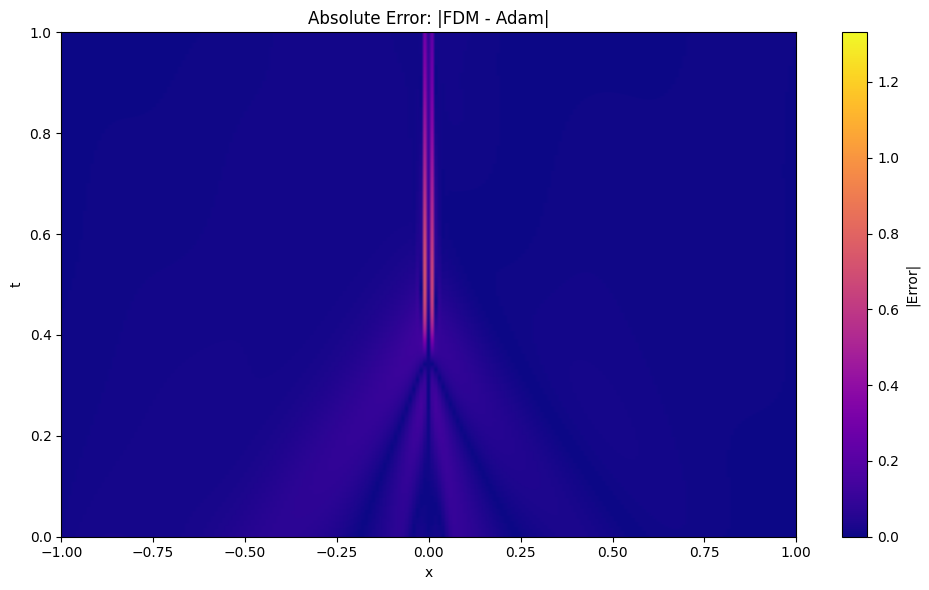

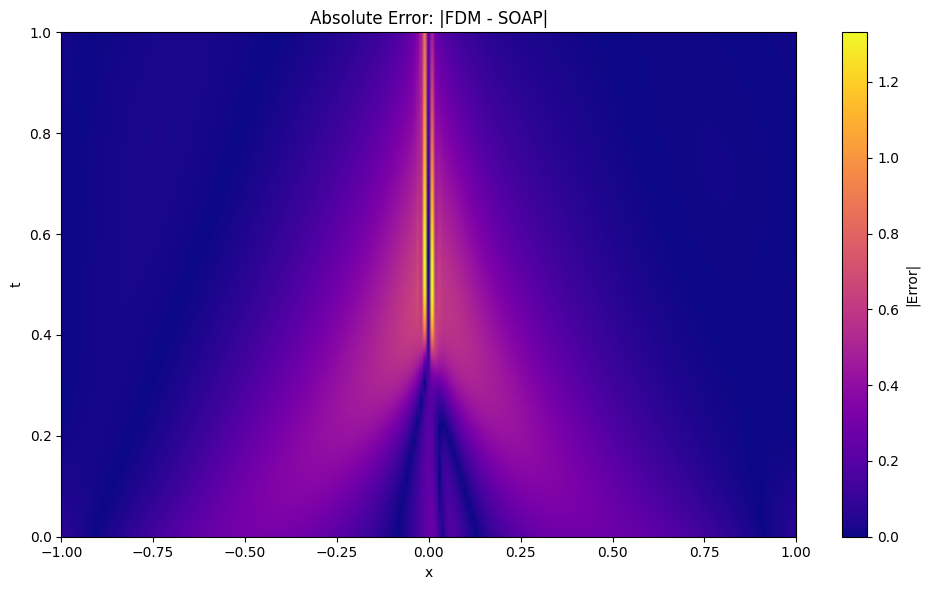

In [15]:
def main():
    rng = jax.random.PRNGKey(0)
    model = PINN()
    print("Training with SOAP Optimizer...")
    soap_init, soap_step = make_soap_trainer(model)
    soap_params, soap_hist = train(rng, model, soap_init, soap_step)
    print("\nTraining with Adam Optimizer...")
    adam_init, adam_step = make_adam_trainer(model)
    adam_params, adam_hist = train(rng, model, adam_init, adam_step)
    print("\nFinal losses → SOAP: ", soap_hist[-1], " | Adam: ", adam_hist[-1])
    compare_with_fdm("fdm_solution.pkl", model, soap_params, adam_params)
main()